In [1]:
import numpy as np
import pandas as pd

# Load the datasets
earthquake_data = pd.read_csv('EarthQuackFiltered.csv')
houston_weather_data = pd.read_csv('HWD.csv')

def purity(cluster_assignments, ground_truth, outliers=False):
    """
    Calculate the purity of a clustering result.
    
    Parameters:
    - cluster_assignments (array-like): Cluster labels assigned to each sample.
    - ground_truth (array-like): True class labels for each sample.
    - outliers (bool): If True, consider cluster 0 as outliers, otherwise ignore it.

    Returns:
    - Purity score as a float if outliers is False.
    - A tuple of purity score and percentage of outliers if outliers is True.
    """
    
    # Filter out outliers if the outliers parameter is True
    if outliers:
        # Identify non-outlier clusters
        non_outliers = cluster_assignments != 0
        filtered_assignments = cluster_assignments[non_outliers]
        filtered_ground_truth = ground_truth[non_outliers]
        num_outliers = len(cluster_assignments) - len(filtered_assignments)
        outlier_percentage = num_outliers / len(cluster_assignments)
    else:
        filtered_assignments = cluster_assignments
        filtered_ground_truth = ground_truth
        outlier_percentage = 0

    # Calculate purity by cluster
    total_correct = 0
    unique_clusters = np.unique(filtered_assignments)
    for cluster in unique_clusters:
        cluster_indices = filtered_assignments == cluster
        true_labels = filtered_ground_truth[cluster_indices]
        if len(true_labels) > 0:
            majority_count = np.max(np.bincount(true_labels))
            total_correct += majority_count

    purity_score = total_correct / len(filtered_assignments)
    
    if outliers:
        return (purity_score, outlier_percentage)
    return purity_score

In [2]:
def asse(cluster_assignments, numerical_values):
    """
    Calculate the Average Sum of Squared Errors (ASSE) for a clustering result.

    Parameters:
    - cluster_assignments (array-like): Cluster labels assigned to each sample.
    - numerical_values (array-like): Numerical attribute values for each sample.

    Returns:
    - ASSE score as a float.
    """
    total_squared_error = 0
    total_samples = 0

    unique_clusters = np.unique(cluster_assignments)
    for cluster in unique_clusters:
        if cluster == 0:
            continue

        # Find all points in this cluster
        cluster_indices = cluster_assignments == cluster
        cluster_values = numerical_values[cluster_indices]
        
        if len(cluster_values) > 0:
            cluster_mean = np.mean(cluster_values)
            squared_error = np.sum((cluster_values - cluster_mean) ** 2)
            total_squared_error += squared_error
            total_samples += len(cluster_values)

    asse_score = total_squared_error / total_samples
    return asse_score

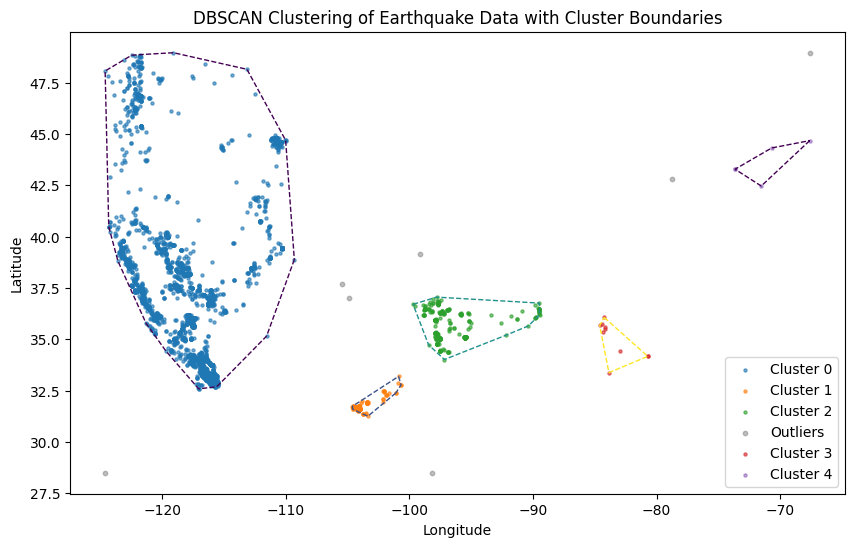

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN

def plot_clusters_with_boundaries(data, cluster_column, title):
    """
    Plots clusters with convex hull boundaries for a specified clustering method.

    Parameters:
    - data: DataFrame containing latitude and longitude data and cluster labels.
    - cluster_column: The column name in `data` that contains the cluster labels.
    - title: Title for the plot.
    """
    
    # Extract latitude and longitude features
    X = data[['latitudes', 'longitudes']]
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)

    # Get unique clusters and define colors for clusters
    labels = data[cluster_column].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(labels) - (1 if -1 in labels else 0)))
    
    # Plot each cluster and create convex hulls for each
    for i, cluster in enumerate(labels):
        if cluster == -1:
            # Outliers
            plt.scatter(data[data[cluster_column] == -1]['longitudes'],
                        data[data[cluster_column] == -1]['latitudes'],
                        color='grey', label='Outliers', s=10, alpha=0.5)
        else:
            # Points in this cluster
            cluster_points = data[data[cluster_column] == cluster][['latitudes', 'longitudes']]
            
            # Plot points
            plt.scatter(cluster_points['longitudes'], cluster_points['latitudes'], s=5, label=f'Cluster {cluster}', alpha=0.6)
            
            # Draw convex hull if there are enough points for a hull
            if len(cluster_points) >= 3:
                hull = ConvexHull(cluster_points)
                hull_points = cluster_points.iloc[hull.vertices]
                plt.plot(hull_points['longitudes'].tolist() + [hull_points['longitudes'].iloc[0]],
                         hull_points['latitudes'].tolist() + [hull_points['latitudes'].iloc[0]], 
                         color=colors[i % len(colors)], linestyle='--', linewidth=1)
    
    plt.legend()
    plt.show()

# Extract latitude and longitude features
X_earthquake = earthquake_data[['latitudes', 'longitudes']]

# Standardize the data
scaler = StandardScaler()
X_earthquake_scaled = scaler.fit_transform(X_earthquake)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_earthquake_scaled)
earthquake_data['dbscan_cluster'] = labels

# Plot clusters with boundaries
plot_clusters_with_boundaries(earthquake_data, 'dbscan_cluster', "DBSCAN Clustering of Earthquake Data with Cluster Boundaries")

,k,depth_asse,magnitude_asse
0,5,22.784957,0.381086
1,9,20.857341,0.379297
2,13,20.599869,0.370114
3,17,19.530480,0.358954


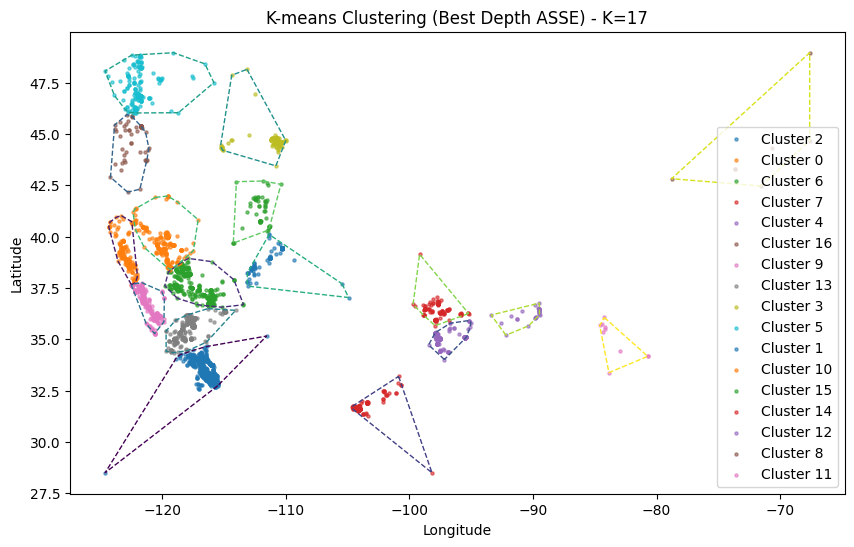

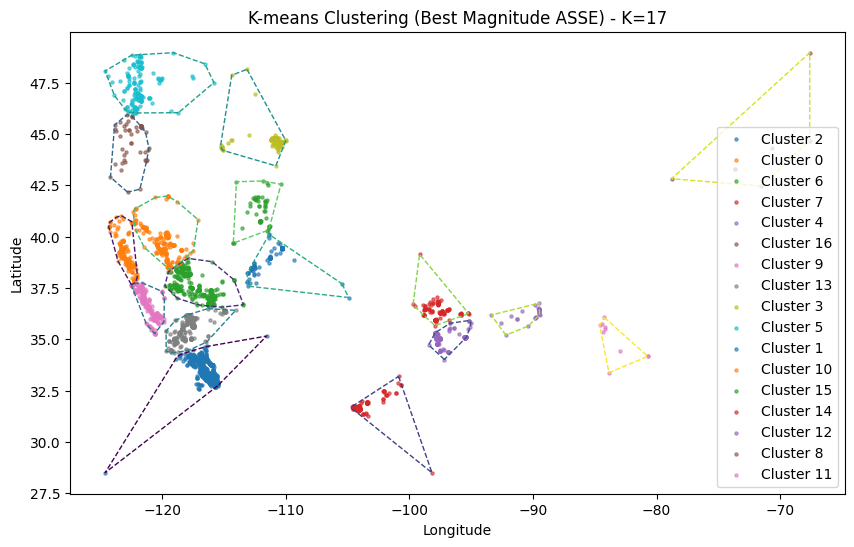

In [4]:
from sklearn.cluster import KMeans

# Extract relevant spatial features (longitude, latitude) and the depth and magnitude
X_earthquake = earthquake_data[['latitudes', 'longitudes']]
depth_values = earthquake_data['depth'].values
magnitude_values = earthquake_data['mag'].values

# Standardize spatial data
scaler = StandardScaler()
X_earthquake_scaled = scaler.fit_transform(X_earthquake)

# Dictionary to store ASSE values for each K
asse_results = {'k': [], 'depth_asse': [], 'magnitude_asse': []}

# Iterate over the specified values of K
for k in [5, 9, 13, 17]:
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_earthquake_scaled)
    
    # Compute ASSE for depth and magnitude
    depth_asse = asse(cluster_labels, depth_values)
    mag_asse = asse(cluster_labels, magnitude_values)
    
    # Store results
    asse_results['k'].append(k)
    asse_results['depth_asse'].append(depth_asse)
    asse_results['magnitude_asse'].append(mag_asse)

asse_df = pd.DataFrame(asse_results)

# Identifying the best K for depth and magnitude based on minimum ASSE values
best_depth_k = asse_df.loc[asse_df['depth_asse'].idxmin(), 'k']
best_magnitude_k = asse_df.loc[asse_df['magnitude_asse'].idxmin(), 'k']

# Best K for Depth
kmeans_depth = KMeans(n_clusters=int(best_depth_k), random_state=42)
earthquake_data['kmeans_depth_cluster'] = kmeans_depth.fit_predict(X_earthquake_scaled)

# Best K for Magnitude
kmeans_magnitude = KMeans(n_clusters=int(best_magnitude_k), random_state=42)
earthquake_data['kmeans_magnitude_cluster'] = kmeans_magnitude.fit_predict(X_earthquake_scaled)

display(asse_df)

# Plot the best depth and magnitude ASSE clustering results
plot_clusters_with_boundaries(earthquake_data, 'kmeans_depth_cluster', f"K-means Clustering (Best Depth ASSE) - K={best_depth_k}")
plot_clusters_with_boundaries(earthquake_data, 'kmeans_magnitude_cluster', f"K-means Clustering (Best Magnitude ASSE) - K={best_magnitude_k}")

Purity Score: 0.5671232876712329
Best SSE: 1601.8448078272904
Cluster Centroids (Original Scale):
 [[7.25863636e+01 8.72590909e+01 8.31818182e-02 1.17681818e+01
  2.98656818e+01 5.51045455e+01 4.78181818e+00]
 [4.85840708e+01 6.85929204e+01 3.09734513e-02 1.12123894e+01
  3.00789381e+01 4.44513274e+01 2.40707965e+00]
 [6.10000000e+01 8.01250000e+01 2.29687500e+00 1.21562500e+01
  2.99037500e+01 7.49062500e+01 8.18750000e+00]]
Cluster Means:
           min_temp   max_temp  rainfall  wind_speed   pressure   humidity  \
cluster                                                                     
0        72.586364  87.259091  0.083182   11.768182  29.865682  55.104545   
1        48.584071  68.592920  0.030973   11.212389  30.078938  44.451327   
2        61.000000  80.125000  2.296875   12.156250  29.903750  74.906250   

         sunshine  
cluster            
0        4.781818  
1        2.407080  
2        8.187500  


<Figure size 640x480 with 0 Axes>

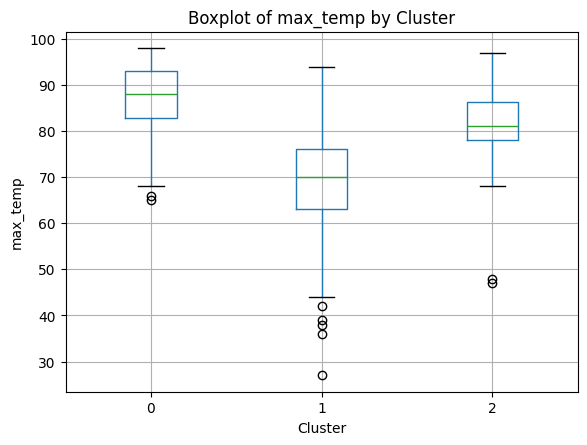

<Figure size 640x480 with 0 Axes>

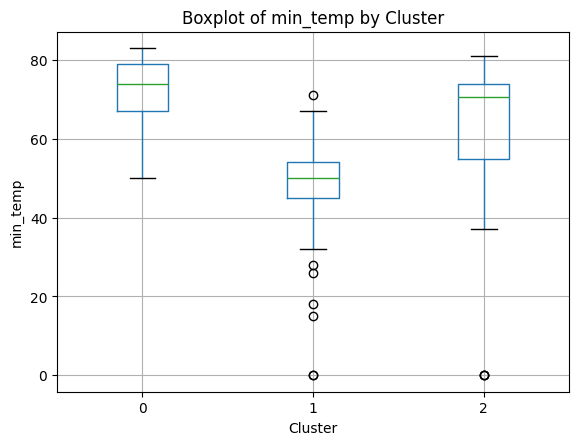

<Figure size 640x480 with 0 Axes>

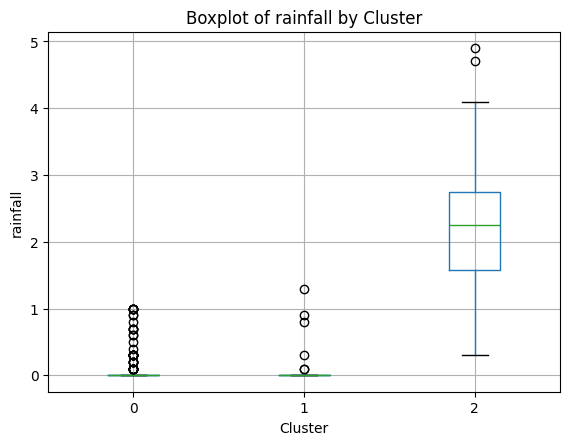

<Figure size 640x480 with 0 Axes>

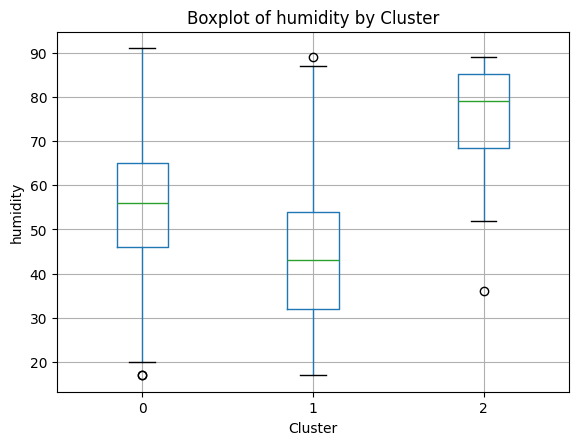

<Figure size 640x480 with 0 Axes>

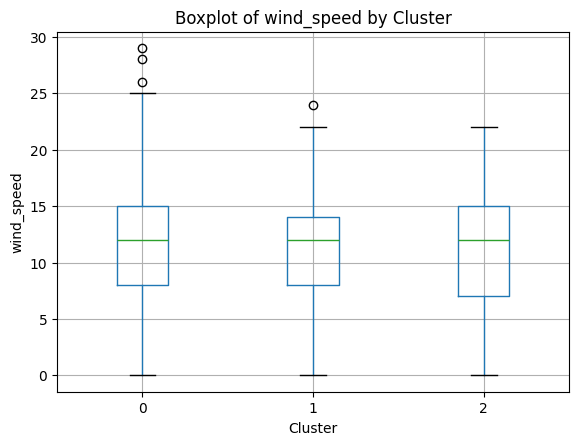

<Figure size 640x480 with 0 Axes>

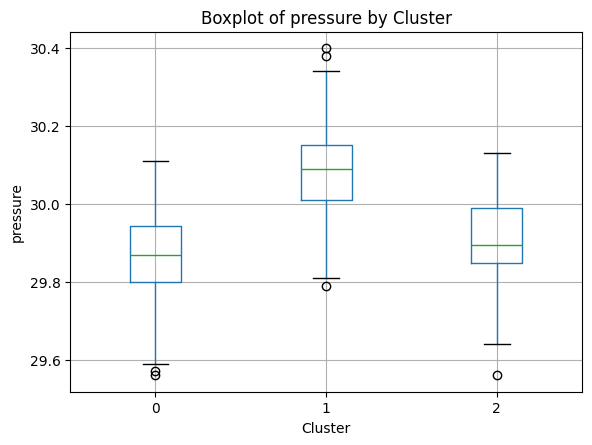

In [5]:
# Exclude Date and Class attributes for clustering
hwd_features = houston_weather_data.drop(columns=['date', 'Class'])

# Standardize the data for K-means
scaler = StandardScaler()
hwd_features_scaled = scaler.fit_transform(hwd_features)

# Run K-means 10 times and track the clustering with the lowest SSE
best_sse = float('inf')
best_kmeans_model = None
for _ in range(10):
    kmeans = KMeans(n_clusters=3, random_state=np.random.randint(10000))
    kmeans.fit(hwd_features_scaled)
    sse = kmeans.inertia_
    if sse < best_sse:
        best_sse = sse
        best_kmeans_model = kmeans

# Best clustering labels
houston_weather_data['cluster'] = best_kmeans_model.labels_

# Compute purity using your existing purity function with ground truth labels
class_labels = houston_weather_data['Class'].apply(lambda x: ord(x) - ord('H')).values  # Convert H, M, L to numeric values
purity_score_kmeans = purity(houston_weather_data['cluster'].values, class_labels)

# Calculate centroids and means for each cluster
centroids = scaler.inverse_transform(best_kmeans_model.cluster_centers_)
numeric_columns = hwd_features.select_dtypes(include=[np.number]).columns
means_by_cluster = houston_weather_data.groupby('cluster')[numeric_columns].mean()

# Display the purity score, centroids, and cluster means
print("Purity Score:", purity_score_kmeans)
print("Best SSE:", best_sse)
print("Cluster Centroids (Original Scale):\n", centroids)
print("Cluster Means:\n", means_by_cluster)

# Generate box plots for specified attributes by cluster
attributes_to_plot = ['max_temp', 'min_temp', 'rainfall', 'humidity', 'wind_speed', 'pressure']

for attribute in attributes_to_plot:
    plt.figure()
    houston_weather_data.boxplot(column=attribute, by='cluster')
    plt.title(f'Boxplot of {attribute} by Cluster')
    plt.suptitle('')
    plt.xlabel("Cluster")
    plt.ylabel(attribute)
    plt.show()

In [6]:
# Exclude Date and Class attributes for clustering
hwd_features = houston_weather_data.drop(columns=['date', 'Class'])

# Standardize the data for DBSCAN
scaler = StandardScaler()
hwd_features_scaled = scaler.fit_transform(hwd_features)

# Initialize variables to track the best DBSCAN model
best_purity = 0
best_dbscan_model = None
best_cluster_labels = None
best_outlier_percentage = None

# Range of parameters for DBSCAN to find the best configuration
for eps in np.arange(0.1, 2.0, 0.1):
    for min_samples in range(3, 15):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(hwd_features_scaled)

        # Calculate the outlier percentage
        num_outliers = sum(cluster_labels == -1)
        outlier_percentage = num_outliers / len(cluster_labels)

        # Check conditions for clusters and outliers
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        if 2 <= num_clusters <= 15 and outlier_percentage < 0.2:
            # Calculate purity
            class_labels = houston_weather_data['Class'].apply(lambda x: ord(x) - ord('H')).values
            purity_result = purity(cluster_labels, class_labels, outliers=True)
            
            # Store scalar and tuple return types from purity function
            purity_score = purity_result if isinstance(purity_result, float) else purity_result[0]

            # The best purity score and corresponding DBSCAN model
            if purity_score > best_purity:
                best_purity = purity_score
                best_dbscan_model = dbscan
                best_cluster_labels = cluster_labels
                best_outlier_percentage = outlier_percentage

# Best DBSCAN purity score, number of clusters, and outlier percentage
purity_score_dbscan = best_purity
num_clusters_dbscan = len(set(best_cluster_labels)) - (1 if -1 in best_cluster_labels else 0)

print("Best DBSCAN Purity Score:", purity_score_dbscan)
print("Number of Clusters with DBSCAN:", num_clusters_dbscan)
print("Outlier Percentage with DBSCAN:", best_outlier_percentage)

# K-means Comparison: 
print("\nK-means Comparison:")
print(f"Purity Score (K-means): {purity_score_kmeans}")
print("Number of Clusters with K-means:", 3)
print("Outlier Percentage with K-means:", 0)

Best DBSCAN Purity Score: 0.7894736842105263
Number of Clusters with DBSCAN: 3
Outlier Percentage with DBSCAN: 0.049315068493150684

K-means Comparison:
Purity Score (K-means): 0.5671232876712329
Number of Clusters with K-means: 3
Outlier Percentage with K-means: 0


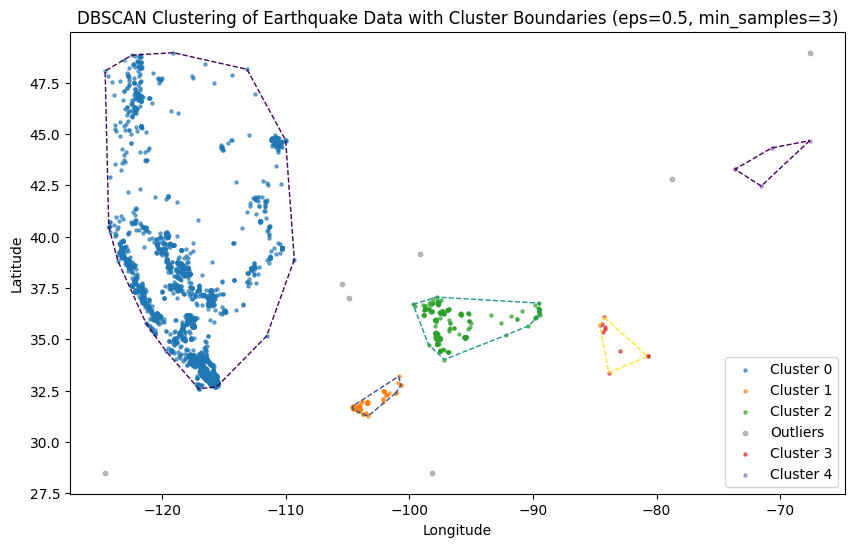

Best DBSCAN ASSE Score: 13.322643956193936
DBSCAN Parameters (eps, min_samples): (0.5, 3)

K-means Comparison:
K-means Purity Score: 0.5671232876712329
K-means Number of Clusters: 3


In [7]:
# Extract latitude, longitude, and depth features
X_earthquake = earthquake_data[['latitudes', 'longitudes']]
depth_values = earthquake_data['depth'].values

# Standardize the spatial data for DBSCAN
scaler = StandardScaler()
X_earthquake_scaled = scaler.fit_transform(X_earthquake)

# Optimized Search for DBSCAN Parameters
best_asse = float('inf')
best_dbscan_model = None
best_cluster_labels = None
best_params = None

# Ranges for eps and min_samples
eps_range = [0.2, 0.5, 0.8, 1.0]
min_samples_range = [3, 5, 7, 10]

for eps in eps_range:
    for min_samples in min_samples_range:
        try:
            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X_earthquake_scaled)

            # Calculate outlier percentage and number of clusters
            num_outliers = sum(cluster_labels == -1)
            outlier_percentage = num_outliers / len(cluster_labels)
            num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

            if 2 <= num_clusters <= 15 and outlier_percentage < 0.2:
                # Calculate ASSE for depth attribute using the updated asse function
                asse_score = asse(cluster_labels, depth_values)
                
                # Track the best ASSE score and corresponding DBSCAN model
                if asse_score < best_asse:
                    best_asse = asse_score
                    best_dbscan_model = dbscan
                    best_cluster_labels = cluster_labels
                    best_params = (eps, min_samples)

        except MemoryError:
            print(f"Skipping eps={eps}, min_samples={min_samples} due to memory issues.")
            continue

# Add the best cluster labels to the earthquake data for visualization
earthquake_data['dbscan_cluster'] = best_cluster_labels

# Visualization of the best DBSCAN clustering with convex hull boundaries
plot_clusters_with_boundaries(
    earthquake_data,
    cluster_column='dbscan_cluster',
    title=f"DBSCAN Clustering of Earthquake Data with Cluster Boundaries (eps={best_params[0]}, min_samples={best_params[1]})"
)

# Results
print("Best DBSCAN ASSE Score:", best_asse)
print("DBSCAN Parameters (eps, min_samples):", best_params)

# Comparison with K-means results
print("\nK-means Comparison:")
print("K-means Purity Score:", purity_score_kmeans)
print("K-means Number of Clusters:", 3)
